Marlon Rodríguez Flor

In [123]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [124]:
def createDataSet(n,model,ymargin,noise=None,output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, (c*1).ravel(), xbnd, ybnd
    else:
        return x, y, (c*1).ravel()

In [125]:
def plotModel(x,y,clase,clf,title=""):
    from matplotlib.colors import ListedColormap
    
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    elif hasattr(clf, "predict_proba"):
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter(x[clase==0], y[clase==0], c='#FF0000')
        plt.scatter(x[clase==1], y[clase==1], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

In [126]:
def plotData(x,y,c,style0,style1,title=''):
    plt.scatter(x[c==0],y[c==0],**style0)
    plt.scatter(x[c==1],y[c==1],**style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

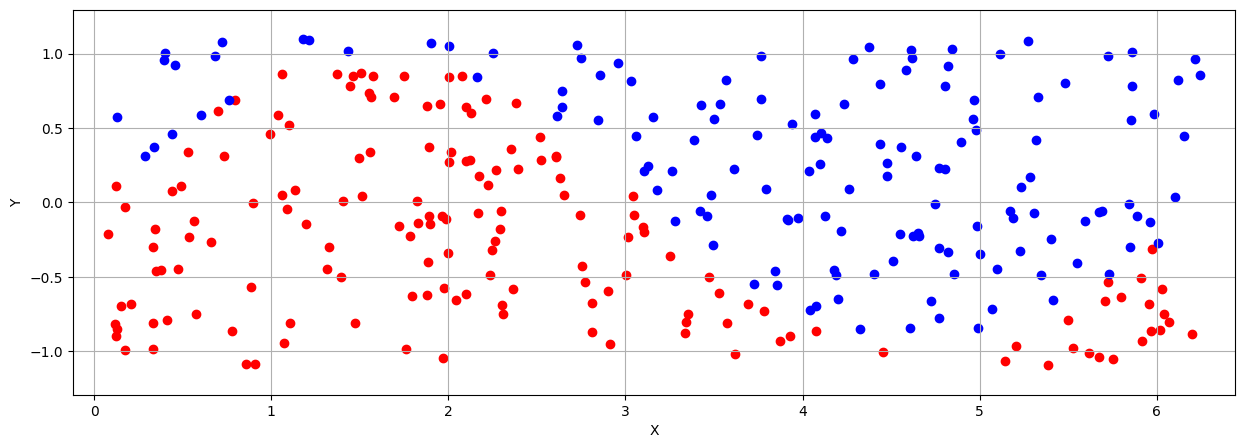

In [127]:
# Problem data:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.0             # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)

x1, x2, ytrain, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
Xtrain = np.concatenate((x1, x2), axis = 1)

x1test, x2test, ytest      = createDataSet(n*10, model, ymargin, noise)
Xtest = np.concatenate((x1test, x2test), axis = 1)

plotData(x1,x2,ytrain,{'c':'#FF0000'},{'c':'#0000FF'})

### Algoritmo gradient boosting (parte 2 de la práctica)
Algoritmo de gradient boosting para implementar. Solo hay que incluir el código en las partes indicadas. Se implementará el algoritmo para regresión y para clasificación

In [128]:
from sklearn.tree import DecisionTreeRegressor

""" Solo se va a implementar para regresión y para clasificación 
    binaria con clases igual a -1 y +1
"""

class SquaredErrorLoss:
    """ Clase que define elementos para la función cuadrática de perdida 
        para regresión """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        return np.mean(y)

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return y - F

    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado alarbol regresor ht
           Además recine el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """
        return valor
    
    def __call__(self, y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return 0.5*(y-F)**2
    
    def getPredictions(self, y):
        return y
    
class LogLoss:
    """ Clase que define elementos para la función logística de perdida 
        para clasificación de dos clases {-1, +1} """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        return 0.5*np.log((1+np.mean(y))/(1-np.mean(y)))

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return (2*y)/(1+np.exp(2*y*F))

    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado alarbol regresor ht
           Además recine el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """

        return np.sum(residuos)/np.sum(np.abs(residuos)*(2-np.abs(residuos)))
    
    def __call__(self,y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return np.log(1+np.exp(-2.0*y*F))
    
    def getPredictions(self, y):
        probs = 1 / (1 + np.exp(-2*y))
        return np.array([1 if i>= 0.5 else -1 for i in probs])

    def getProba(self,y):
        return 1 / (1 + np.exp(-2*y))
        
    
class GBCasero:
    def __init__(self, n_estimators=101, loss=SquaredErrorLoss(), eta=0.1, depth=3):
        self.n_estimators = n_estimators
        self._estimators  = []
        self.depth        = depth
        self.eta          = eta
        # La implementación de loss se usará en fit para crear el algoritmo
        # GB de forma genérica.
        self.loss         = loss
    
    def fit(self,X,y):
        """
          Inicializa GB 
        """
        F = 0
        for i in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth = self.depth)
            """
              Rellenar esta parte para implementar GB 
              Se debe utilizar la función paso_newton de abajo
            """
            pseudo_residuals = self.loss.residuos(y,F)
            tree = tree.fit(X,pseudo_residuals)
            self.paso_newton_general(tree, X, y, pseudo_residuals)
            self._estimators.append(tree)
            F += self.eta * tree.predict(X)
            
    def predict(self,X):
        """ Combinamos los valores de pesos y hs para obtener la 'salida' o
             predicciones en crudo, y que haga:
               * Para regresión se devuelve 'salida'
               * Para clasificación de 2 clases se calcula la probabilidad
                  con una sigmoidal (1 / (1 + np.exp(-2*salida))) y se 
                  devuelve la clase más probable 
                  
            Nota1: Podéis delegar esto a las funciones de pérdida para evitar 
                   poner aquí in if
            Nota2: Podéis también organizar la clasificacion/regresion al estilo
                   sklearn e implementar predict_proba en la clasificación.
                
        """
        result = 0
        for estimador in self._estimators:
            result+= estimador.predict(X)*self.eta
        return self.loss.getPredictions(result) 
    
    def predict_proba(self, X):
        result = 0
        for estimador in self._estimators:
            result+= estimador.predict(X)*self.eta

        c1 = self.loss.getProba(result)
        c0 = 1 - c1
        return np.column_stack((c0, c1))

        
    def paso_newton_general(self, tree, X, y, residuos):
        """ Esta función actualiza todas las hojas de salida
            del árbol 'tree' utilizado la función paso_newton_hoja
            de las clases de funcion de pérdida """
        TREE_LEAF = -1
        tree = tree.tree_
        leaf_indices = tree.apply(np.array(X,dtype=np.float32))
        for leaf in np.where(tree.children_left == TREE_LEAF)[0]:
            ii = leaf_indices==leaf
            tree.value[leaf,0,0] = self.loss.paso_newton_hoja(y[ii],
                                                              residuos[ii],
                                                              tree.value[leaf,0,0])


### Performance Gradient Boosting Casero vs Implementación Sklearn

#### 1. Clasificación

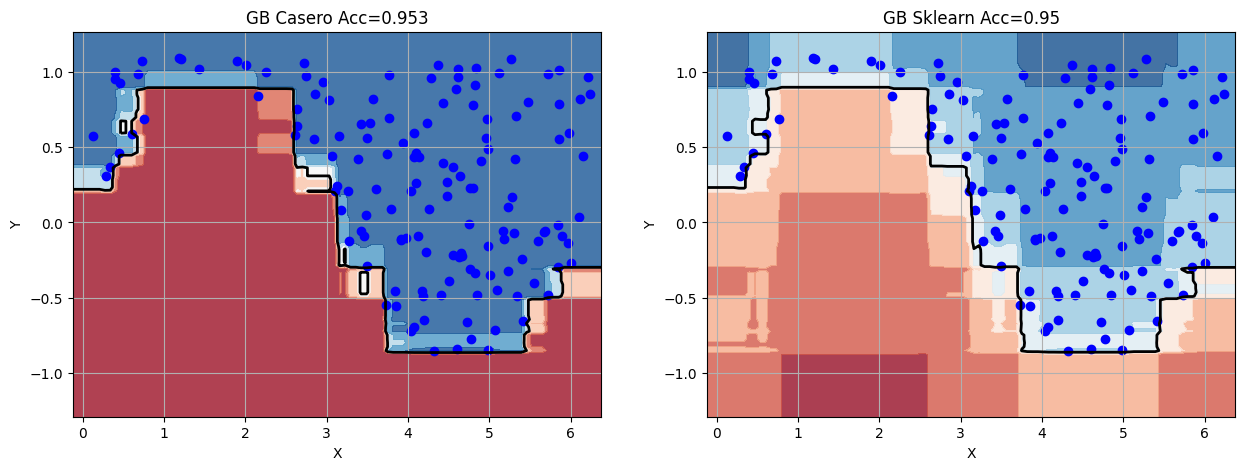

In [129]:
import matplotlib
matplotlib.rc('figure', figsize=(15, 5))
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

# Basic example
gb = GBCasero(loss=LogLoss())
gb_sk = GradientBoostingClassifier(n_estimators=101, loss='log_loss', learning_rate=0.1, max_depth=3)

lb     = LabelBinarizer(pos_label = 1, neg_label = -1)
ytrain = lb.fit_transform(ytrain).ravel()
ytest  = lb.transform(ytest).ravel()

plt.subplot(1, 2, 1)
gb.fit(Xtrain, ytrain)
acc = np.sum(gb.predict(Xtest)==ytest)/len(ytest)
plotModel(x1,x2,ytrain,gb,"GB Casero Acc="+str(acc))

plt.subplot(1, 2, 2)
gb_sk.fit(Xtrain, ytrain)
acc_sk = np.sum(gb_sk.predict(Xtest)==ytest)/len(ytest)
plotModel(x1,x2,ytrain,gb_sk,"GB Sklearn Acc="+str(acc_sk))

In [130]:
# Magic
fP = 'magic04.csv'
dfP = pd.read_csv(fP, sep=',')

X_tr, X_ts, y_tr, y_ts = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], 
                                          test_size=0.8, random_state=1)
lb   = LabelBinarizer(pos_label = 1, neg_label = -1)
y_tr = lb.fit_transform(y_tr).ravel()
y_ts = lb.transform(y_ts).ravel()

gb = GBCasero(loss=LogLoss())
gb_sk = GradientBoostingClassifier(n_estimators=101, loss='log_loss', learning_rate=0.1, max_depth=3)

gb.fit(X_tr, y_tr)
print("Accuracy in Magic04 GB Casero =",np.sum(gb.predict(X_ts)==y_ts)/len(y_ts))

gb_sk.fit(X_tr, y_tr)
print("Accuracy in Magic04 GB Sklearn =",np.sum(gb_sk.predict(X_ts)==y_ts)/len(y_ts))

Accuracy in Magic04 GB Casero = 0.8627103049421662
Accuracy in Magic04 GB Sklearn = 0.862053101997897


#### 2. Regresión

Error Cuadrático Medio (MSE):
  -Implementación Casera: 3.243890
  -Implementación Sklearn: 3.243842


Text(0.5, 1.0, 'Comparación implementación casera vs Sklearn en datos de Test')

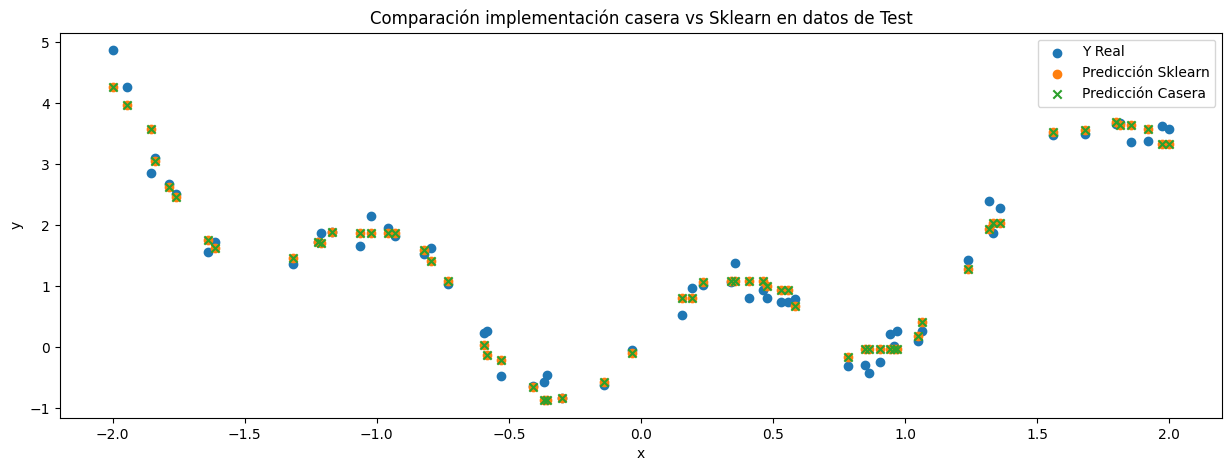

In [131]:
from sklearn.model_selection import train_test_split

# Creación Dataset
n_pat = 300
noise = 0.2
np.random.seed(1)
x_r = np.linspace(-2, 2, n_pat)
y_r = np.square(x_r) + np.sin(5 * x_r) + noise * np.random.randn(n_pat)
X_train, X_test, y_train, y_test = train_test_split(x_r, y_r, test_size=0.2, random_state=1)
X_train  = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

# Entrenamiento GB Casero e Implementación Sklearn
gb = GBCasero(loss=SquaredErrorLoss())
gb_sk = GradientBoostingRegressor(loss="squared_error",n_estimators=101, learning_rate=0.1,max_depth=3)

gb.fit(X_train, y_train)
gb_sk.fit(X_train, y_train)

# Predict
preds = gb.predict(X_test)
preds2 = gb_sk.predict(X_test)

# MSE
mse_pred = sum((preds - y_test)**2)
mse_pred2 = sum((preds2 - y_test)**2)

print('Error Cuadrático Medio (MSE):\n  -Implementación Casera: %f\n  -Implementación Sklearn: %f'%(mse_pred, mse_pred2))

plt.scatter(X_test, y_test, label = 'Y Real', marker='o')
plt.scatter(X_test, preds2, label = 'Predicción Sklearn', marker='o')
plt.scatter(X_test, preds, label = 'Predicción Casera', marker='x')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparación implementación casera vs Sklearn en datos de Test')

In [132]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y = True)

print('Dimensión X:', X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

gb = GBCasero(loss=SquaredErrorLoss())
gb_sk = GradientBoostingRegressor(loss="squared_error",n_estimators=101, learning_rate=0.1,max_depth=3)


gb.fit(X_train, y_train)
gb_sk.fit(X_train, y_train)

# Predict
preds = gb.predict(X_test)
preds2 = gb_sk.predict(X_test)

# MSE
mse_pred = sum((preds - y_test)**2)
mse_pred2 = sum((preds2 - y_test)**2)

print('Error Cuadrático Medio (MSE):\n  -Implementación Casera: %f\n  -Implementación Sklearn: %f'%(mse_pred, mse_pred2))

Dimensión X: (442, 10)
Error Cuadrático Medio (MSE):
  -Implementación Casera: 337633.484829
  -Implementación Sklearn: 335596.950888
